###参考
*   http://www.stat.go.jp/training/2kenkyu/ihou/72/pdf/2-2-723.pdf
*   https://www.boj.or.jp/research/wps_rev/wps_2010/data/wp10j12.pdf(日銀)
*   https://stackoverflow.com/questions/17725927/boxplots-in-matplotlib-markers-and-outliers



## 1.外れ値が与える影響

外れ値は回帰分析やロジスティクス回帰のような線形モデルの結果に影響を与えます。

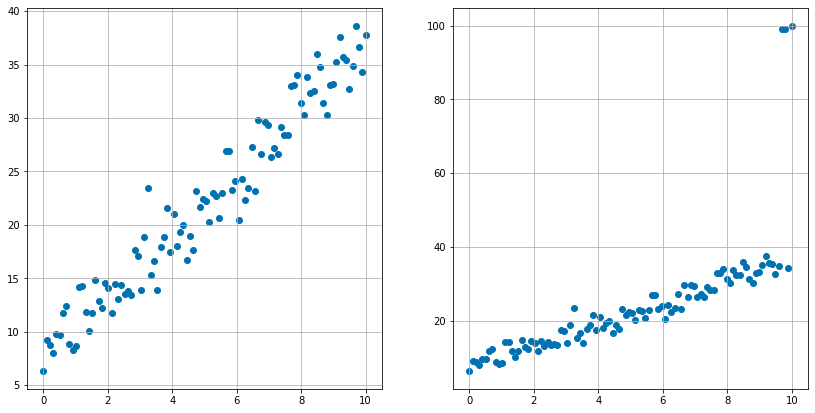

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import *
plt.style.use('seaborn-colorblind')
#y=3x+7のデータを作成
np.random.seed(seed=32)
x = np.linspace(0,10,100)
y = 3*x + randn(100)*2 + 7

fig , ax  = plt.subplots(1,2,figsize=(14,7)) 
ax[0].scatter(x,y)
ax[0].grid(True)
y1=y.copy()
#外れ値を意図的に発生させる
y1[x==x.max()] = 100
y1[96:98] = 99
ax[1].scatter(x,y1)
ax[1].grid(True)

[2.91702475]
[3.96822796]


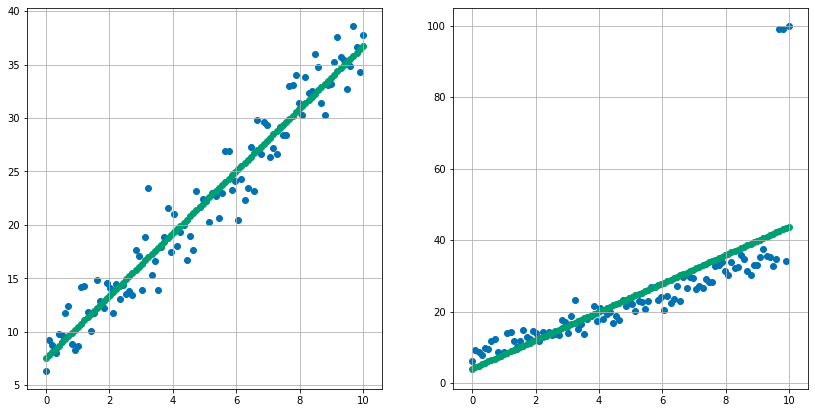

In [0]:
#直線あてはめ
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
fig , ax  = plt.subplots(1,2,figsize=(14,7))
#元のデータ
reg.fit(x.reshape(-1,1),y)
ax[0].scatter(x,y)
ax[0].grid(True)
ax[0].scatter(x,reg.coef_*x+reg.intercept_)
print (reg.coef_)
#外れ値データ
reg.fit(x.reshape(-1,1),y1)
ax[1].scatter(x,y1)
ax[1].grid(True)
ax[1].scatter(x,reg.coef_*x+reg.intercept_)
print (reg.coef_)

上記のように直線が少数の外れ値に引っ張られる。

外れ値処理を行ったモデルの運用について
本稿は外れ値の処理のロジックよりも外れ値処理をどのデータに適用するか具体的には訓練データ検証データ、本番用のスコアリングデータいずれのタイミングでどのような処理を行うのが良いか考察する。

まず外れ値の処理方法として99%/95%タイル丸めを用います。そして丸めの対象となるデータのパターンごとにサンプルデータで予測を行い、検証用のスコアを比較します。






In [1]:
#外れ値処理
import pandas as pd
import numpy as np
from pandas import DataFrame,Series
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 例としてbostonデータセットを用いる

scikit-learnのtoyデータセット。bostonの住宅価格をターゲット変数とする、連続値を予測に適したデータセット。内容は以下の通り。

In [0]:
#データ作成
boston = load_boston()
X = DataFrame(boston.data)
y = Series(boston.target)
X.columns = boston.feature_names

In [4]:
#統計量
X.describe(include='all').T

,count,mean,std,min,25%,50%,75%,max
CRIM,506.0,3.613524,8.601545,0.00632,0.082045,0.25651,3.677083,88.9762
ZN,506.0,11.363636,23.322453,0.00000,0.000000,0.00000,12.500000,100.0000
INDUS,506.0,11.136779,6.860353,0.46000,5.190000,9.69000,18.100000,27.7400
CHAS,506.0,0.069170,0.253994,0.00000,0.000000,0.00000,0.000000,1.0000
NOX,506.0,0.554695,0.115878,0.38500,0.449000,0.53800,0.624000,0.8710
RM,506.0,6.284634,0.702617,3.56100,5.885500,6.20850,6.623500,8.7800
AGE,506.0,68.574901,28.148861,2.90000,45.025000,77.50000,94.075000,100.0000
DIS,506.0,3.795043,2.105710,1.12960,2.100175,3.20745,5.188425,12.1265
RAD,506.0,9.549407,8.707259,1.00000,4.000000,5.00000,24.000000,24.0000
TAX,506.0,408.237154,168.537116,187.00000,279.000000,330.00000,666.000000,711.0000


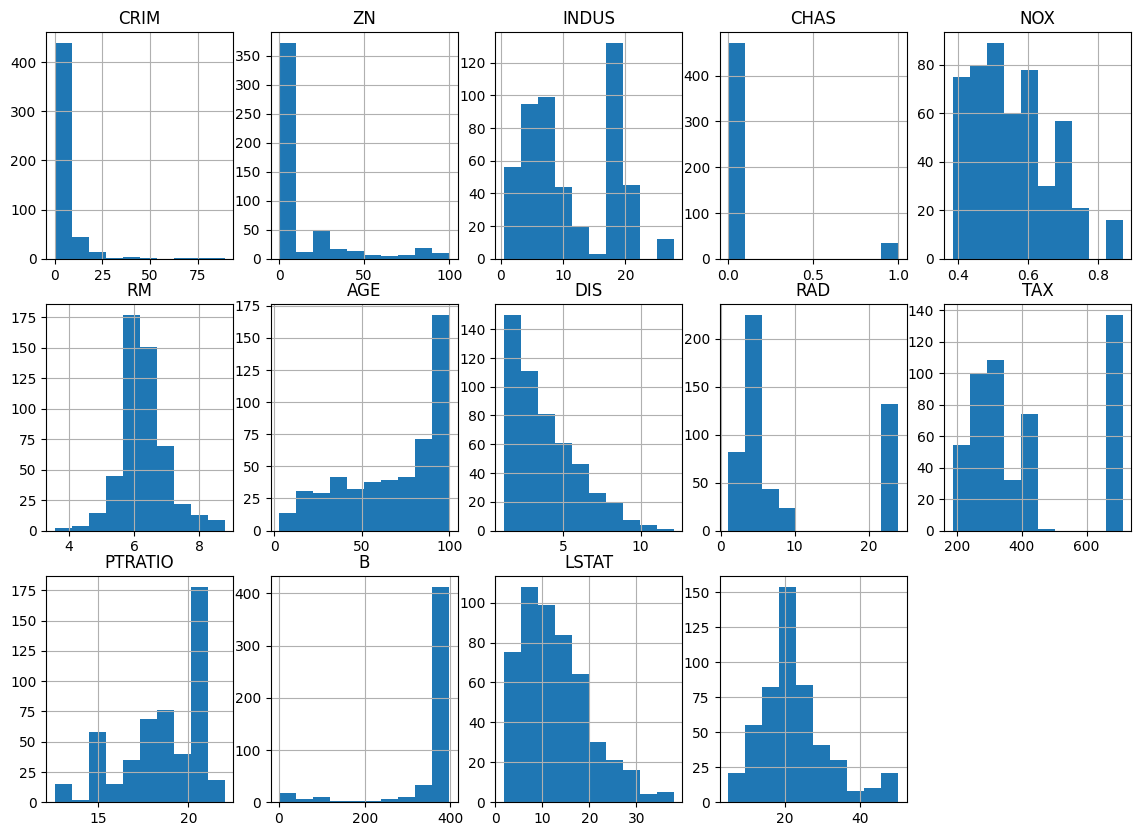

In [5]:
#ヒストグラム
plt.style.use('default')
plt.figure(figsize=(14,10))
for i,col in enumerate(X.columns):
  #print (col)
  plt.subplot(3,5,i+1)
  plt.hist(X.loc[:,col])
  plt.title(col)
  plt.grid(True)
  
plt.subplot(3,5,14)
plt.hist(y)
plt.grid(True)

{'boxes': [<matplotlib.lines.Line2D at 0x7f865a68dc18>],
 'caps': [<matplotlib.lines.Line2D at 0x7f865a6ccf60>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f865a6cc780>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f865a6cc2e8>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f865a68df98>,
  <matplotlib.lines.Line2D at 0x7f865a6cc978>]}

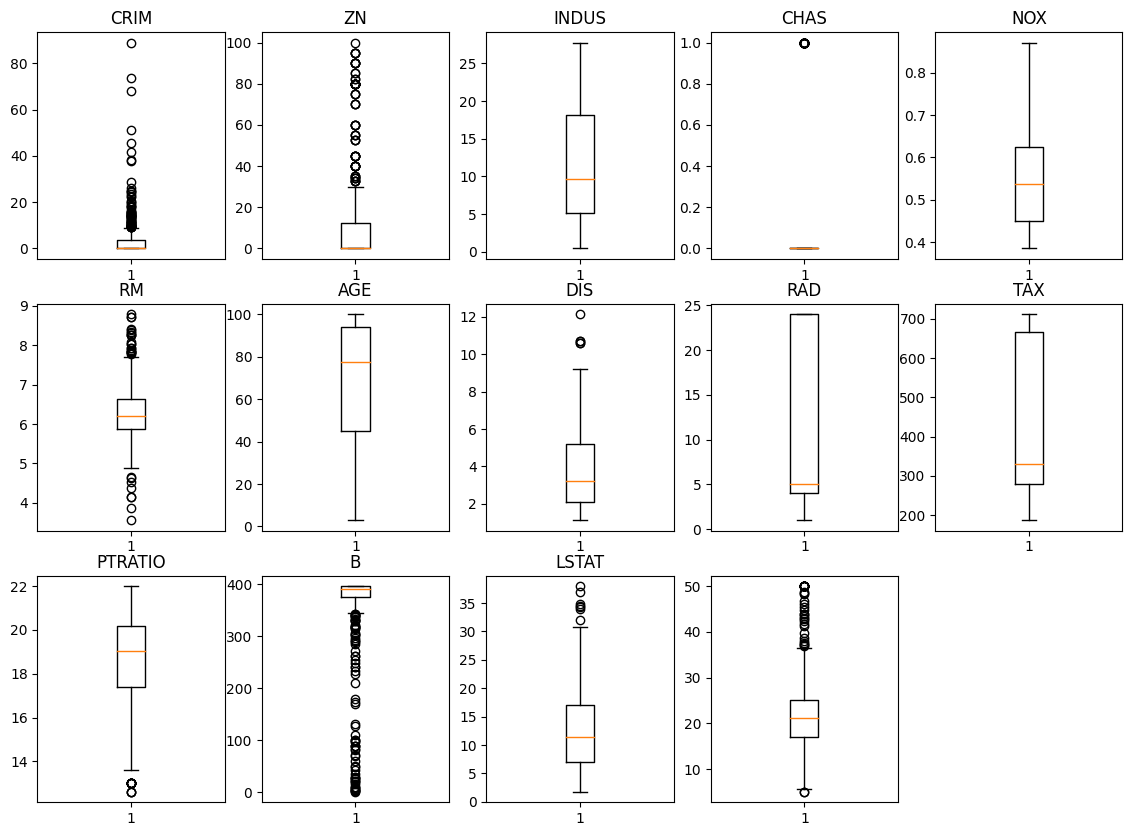

In [6]:
#箱ひげ図
plt.style.use('default')
plt.figure(figsize=(14,10))
for i,col in enumerate(X.columns):
  #print (col)
  plt.subplot(3,5,i+1)
  plt.boxplot(X.loc[:,col])
  plt.title(col)
  
plt.subplot(3,5,14)
plt.boxplot(y)

CRIM/ZN/RM/B/LSTAT/targetに外れ値があるようです。





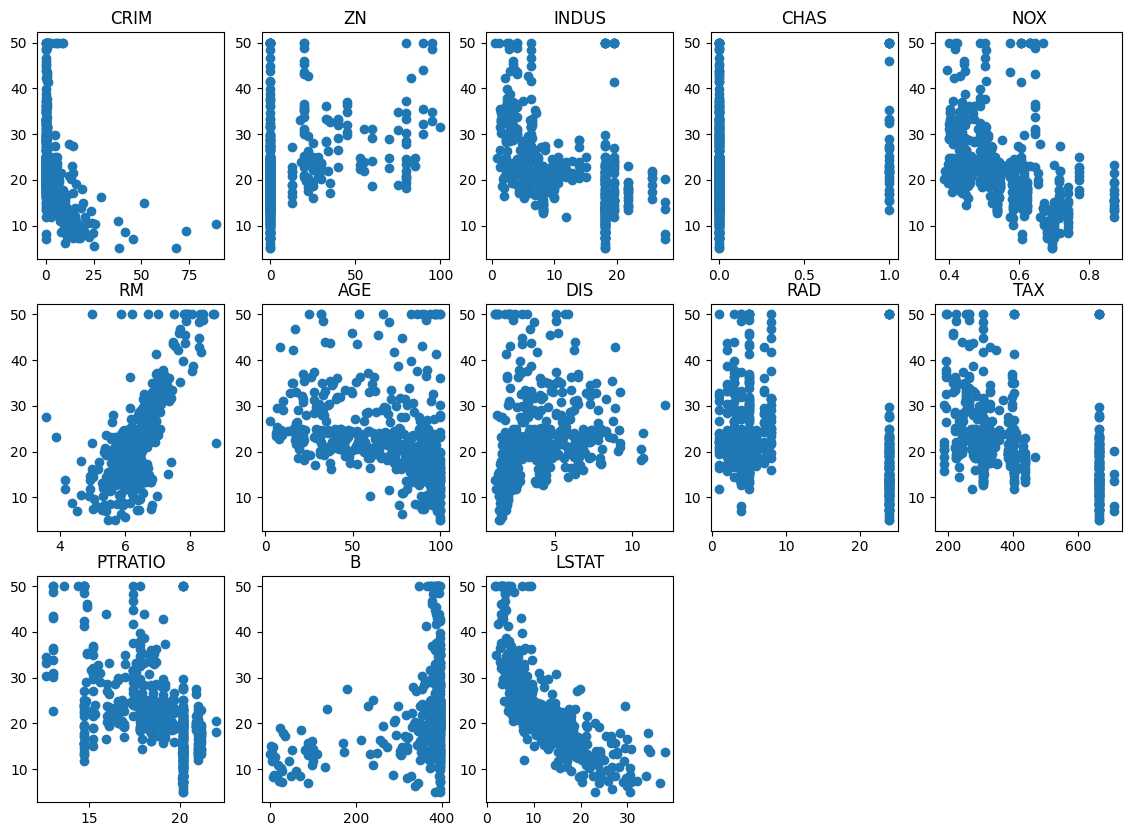

In [7]:
#targetとの散布図
plt.figure(figsize=(14,10))
for i,col in enumerate(X.columns):
  plt.subplot(3,5,i+1)
  plt.scatter(X.loc[:,col],y)
  plt.title(col)

In [8]:
#外れ値処理をしないで回帰してみる
X_train, X_test, y_train, y_test = train_test_split( \
                                   X, y, test_size=0.2, random_state=42)
reg = LinearRegression().fit(X_train, y_train)
print ('訓練：{}'.format(mean_squared_error(y_train,reg.predict(X_train))))
print ('検証：{}'.format(mean_squared_error(y_test,reg.predict(X_test))))

訓練：21.641412753226323
検証：24.291119474973616


In [0]:
#外れ値処理対象カラム定義
cols = ['CRIM','ZN','RM','B','LSTAT']

In [10]:
#丸目関数作成
def roundout(col,pct,train_col):
  pct_low = np.percentile(train_col,pct)
  pct_high = np.percentile(train_col,100-pct)
  col[col<pct_low] = pct_low
  col[col>pct_high] = pct_high
  return (col)

roundout(X_train['CRIM'],1,X_train['CRIM'])

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


477    15.02340
15      0.62739
332     0.03466
423     7.05042
19      0.72580
         ...   
106     0.17120
270     0.29916
348     0.01501
435    11.16040
102     0.22876
Name: CRIM, Length: 404, dtype: float64

In [0]:
#①-1 訓練データ基準で5%/95%タイル除去 Xのみ train のみ
th = X_train.describe(percentiles=[0.05,0.95]).loc[['5%','95%']] 
l = []
for col in cols:
  temp = X_train[col][~((X_train[col]<th.loc['5%',col]) | \
               (X_train[col]>th.loc['95%',col]))]
  l.append(temp)

In [0]:
X_train_out_delete = X_train.loc[pd.concat(l,axis=1,join='inner').index,:]
y_train_out_delete = y_train[pd.concat(l,axis=1,join='inner').index]

In [14]:
X_train_out_delete.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000,294.000000
mean,1.833812,9.159864,10.719864,0.071429,0.549496,6.257449,67.902381,3.860321,8.360544,384.802721,18.364966,375.325476,11.724966
std,3.332158,18.699481,6.598593,0.257978,0.110877,0.456023,27.146013,1.944604,7.809984,154.304125,2.202410,50.889281,5.081173
min,0.029850,0.000000,1.250000,0.000000,0.392000,5.390000,2.900000,1.129600,1.000000,188.000000,12.600000,88.010000,3.730000
25%,0.082757,0.000000,5.190000,0.000000,0.454250,5.924500,45.625000,2.258900,4.000000,279.000000,16.825000,378.275000,7.532500
50%,0.210995,0.000000,8.350000,0.000000,0.532000,6.174000,74.900000,3.373950,5.000000,309.000000,18.650000,392.605000,10.875000
75%,1.351750,12.500000,18.100000,0.000000,0.609000,6.510750,92.600000,5.372350,7.000000,432.000000,20.200000,396.237500,15.020000
max,15.288000,80.000000,27.740000,1.000000,0.871000,7.520000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,26.820000


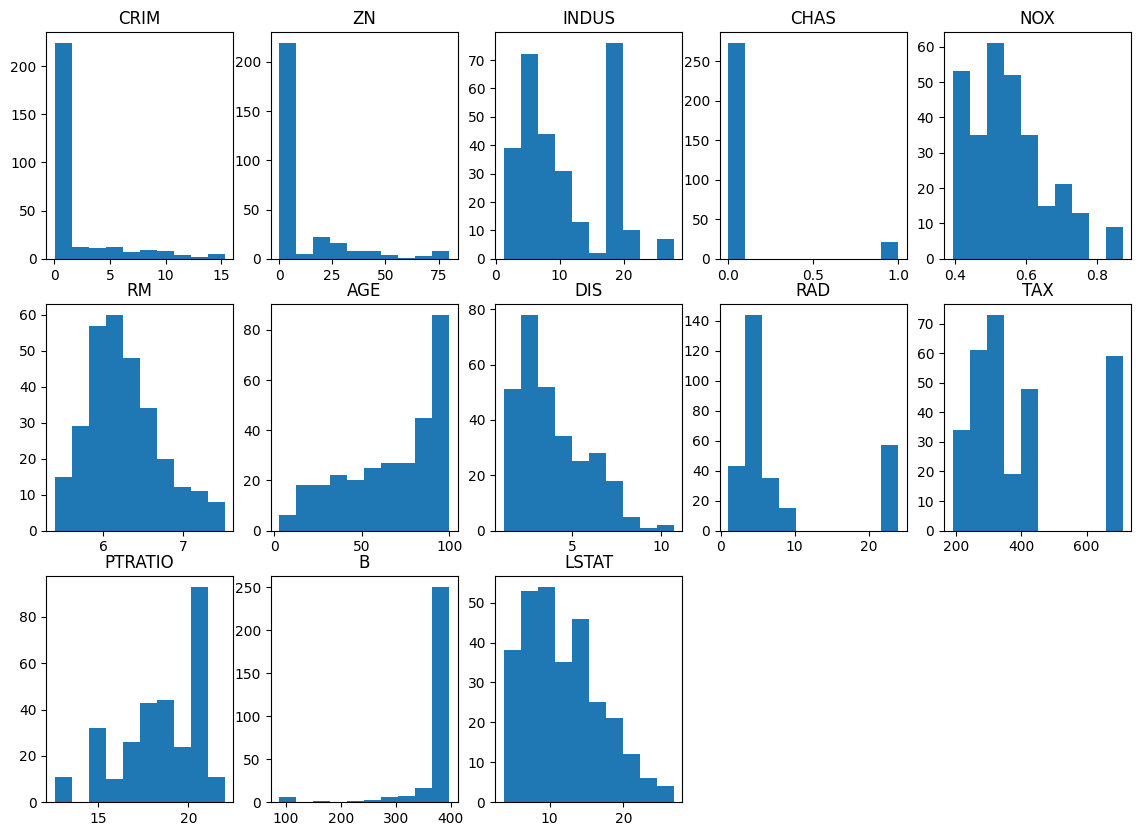

In [15]:
#ヒストグラム
plt.style.use('default')
plt.figure(figsize=(14,10))
for i,col in enumerate(X.columns):
  #print (col)
  plt.subplot(3,5,i+1)
  plt.hist(X_train_out_delete.loc[:,col])
  plt.title(col)
  
#plt.subplot(3,5,14)
#plt.boxplot(y)

In [16]:
reg = LinearRegression().fit(X_train_out_delete, y_train_out_delete)
print ('訓練：{}'.format(mean_squared_error(y_train_out_delete,reg.predict(X_train_out_delete))))
print ('検証：{}'.format(mean_squared_error(y_test,reg.predict(X_test))))

訓練：12.384543317159611
検証：26.58908398347306


In [0]:
#①-2 訓練データ基準で5%/95%タイル除去 Xのみ train testも
th = X_train.describe(percentiles=[0.05,0.95]).loc[['5%','95%']] 
l = []
for col in cols:
  temp = X_test[col][~((X_test[col]<th.loc['5%',col]) | \
               (X_test[col]>th.loc['95%',col]))]
  l.append(temp)
  
X_test_out_delete = X_test.loc[pd.concat(l,axis=1,join='inner').index,:]
y_test_out_delete = y_test[pd.concat(l,axis=1,join='inner').index]

In [18]:
reg = LinearRegression().fit(X_train_out_delete, y_train_out_delete)
print ('訓練：{}'.format(mean_squared_error(y_train_out_delete,reg.predict(X_train_out_delete))))
print ('検証：{}'.format(mean_squared_error(y_test_out_delete,reg.predict(X_test_out_delete))))

訓練：12.384543317159611
検証：14.60239626815001


In [0]:
X_test.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000,102.000000
mean,3.630947,10.549020,11.737745,0.058824,0.547609,6.160833,68.648039,3.742949,10.313725,424.892157,18.999020,358.241275,13.428235
std,7.459607,24.083242,6.722576,0.236456,0.108602,0.663825,28.890866,2.010749,9.161889,177.462472,1.800577,90.641872,7.244601
min,0.006320,0.000000,0.460000,0.000000,0.392000,3.561000,6.200000,1.169100,1.000000,188.000000,13.000000,6.680000,2.880000
25%,0.087368,0.000000,6.102500,0.000000,0.448250,5.870250,43.800000,2.263950,4.000000,281.750000,18.400000,375.020000,7.687500
50%,0.209885,0.000000,10.590000,0.000000,0.532000,6.170500,74.700000,3.353400,5.000000,345.000000,19.200000,392.205000,12.335000
75%,4.522473,0.000000,18.100000,0.000000,0.621500,6.479250,95.225000,4.764825,24.000000,666.000000,20.200000,396.900000,18.017500
max,45.746100,95.000000,27.740000,1.000000,0.871000,8.034000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,36.980000


但しこれでは外れ値を除外してしまっているため、予測が付与できないデータができてしまう


In [0]:
#②-1 訓練データ基準で5%/95%タイルをまるめて埋める Xのみ train のみ
X_train_out_imp = X_train.copy()
for col in cols:
  X_train_out_imp.loc[:,col] =roundout(X_train_out_imp.loc[:,col],5,X_train_out_imp.loc[:,col])

In [20]:
reg = LinearRegression().fit(X_train_out_imp, y_train)
print ('訓練：{}'.format(mean_squared_error(y_train,reg.predict(X_train_out_imp))))
print ('検証：{}'.format(mean_squared_error(y_test,reg.predict(X_test))))

訓練：20.77707473118816
検証：31.867004690125


In [0]:
#②-2 訓練データ基準で5%/95%タイルをまるめて埋める Xのみ train testも
#test
X_test_out_imp = X_test.copy()
for col in cols:
  X_test_out_imp.loc[:,col] = roundout(X_test_out_imp.loc[:,col],5,X_train_out_imp.loc[:,col])

In [22]:
reg = LinearRegression().fit(X_train_out_imp, y_train)
print ('訓練：{}'.format(mean_squared_error(y_train,reg.predict(X_train_out_imp))))
print ('検証：{}'.format(mean_squared_error(y_test,reg.predict(X_test_out_imp))))

訓練：20.77707473118816
検証：21.026068089496707


yもやってみる

In [0]:
#④ターゲット変数も外れ値処理をする 当然のことながらtestデータはこの処理ができない
y_train_out_imp = y_train.copy()
y_train_out_imp = roundout(y_train_out_imp,5,y_train_out_imp) 

In [24]:
reg = LinearRegression().fit(X_train_out_imp, y_train_out_imp)
print ('訓練：{}'.format(mean_squared_error(y_train,reg.predict(X_train_out_imp))))
print ('検証：{}'.format(mean_squared_error(y_test,reg.predict(X_test_out_imp))))

訓練：21.331826131839826
検証：20.299397653484966
